In [62]:
import pandas as pd
import numpy as np
import os


path = "/Users/irtg/同步空间/Pricing_Kernel/EPK/matlab_code_for_BTC"
os.chdir(path)

data_path = os.path.join(path, "data", "processed","20172022_processed_1_3_4.csv")

# Load the dataset
df = pd.read_csv(data_path)

# Convert 'date' to datetime type for easy grouping
df['date'] = pd.to_datetime(df['date'])

# Data cleaning: Drop rows with IV <= 0 or tau < 3
df = df[(df['IV'] > 0) & (df['tau'] >= 3)]

# Filter out rows where 'quantity' is zero before applying aggregation
df = df[df['quantity'] > 0]

# Calculate the moneyness: moneyness = K/S - 1
df['moneyness'] = df['K'] / df['BTC_price'] - 1

# Filter out call options with moneyness < 0 or put options with moneyness > 0
df = df[(df['putcall'] == 'C') & (df['moneyness'] >= 0) | (df['putcall'] == 'P') & (df['moneyness'] <= 0)].reset_index(drop=True)

# Merge rows with the same 'date', 'BTC_price', 'option_price', 'tau', 'K', 'IV', 'putcall' but different 'quantity'
df = df.groupby(['date', 'BTC_price', 'tau', 'K', 'putcall', 'moneyness'], as_index=False).agg({
    'quantity': 'sum',
    'option_price': lambda x: np.average(x, weights=df.loc[x.index, 'quantity']),
    'IV': lambda x: np.average(x, weights=df.loc[x.index, 'quantity'])
    })

# Merge rows with the same 'date', 'tau', 'putcall', 'moneyness' but different 'option_price', 'IV', 'quantity'
df = df.groupby(['date', 'tau', 'putcall', 'moneyness'], as_index=False).agg({
    'quantity': 'sum',
    'option_price': lambda x: np.average(x, weights=df.loc[x.index, 'quantity']),
    'IV': lambda x: np.average(x, weights=df.loc[x.index, 'quantity'])
    })

# Initialize an empty list to store the ATM IV values for each date
iv_atm_list = []
# Iterate through each unique date and tau to find the ATM IV (where moneyness is closest to 0)
for (date, tau), group in df.groupby(['date', 'tau']):
    closest_row = group.iloc[(group['moneyness']).abs().argsort()[:1]]  # Closest row to moneyness = 0
    iv_atm = closest_row['IV'].values[0]
    moneyness_atm = closest_row['moneyness'].values[0]
    iv_atm_list.append({'date': date, 'tau': tau, 'IV_atm': iv_atm, 'moneyness_atm': moneyness_atm})

# Create a DataFrame from the ATM IV list
iv_atm_df = pd.DataFrame(iv_atm_list)

# Merge the ATM IV values back into the original dataframe
df = df.merge(iv_atm_df, on=['date', 'tau'], how='left')

# Calculate standardized moneyness: standardized_moneyness = (K/S - 1) / IV_atm
# Multiply by 100 for scaling
df['standardized_moneyness'] = df['moneyness']/ df['IV_atm'] * 100

# Save the result to a new CSV file
save_path = os.path.join(path, "data", "processed", "20172022_processed_1_3_5_standardized_moneyness.csv")
df.to_csv(save_path, index=False)

print("Standardized moneyness calculation completed and saved to '20172022_processed_1_3_5_standardized_moneyness.csv'")

# Save the ATM IV values to a new CSV file
save_path = os.path.join(path, "data", "IV", "ATM", "20172022_ATM_IV.csv")
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
iv_atm_df.to_csv(save_path, index=False)

print("ATM IV values saved to '20172022_ATM_IV.csv'")



Standardized moneyness calculation completed and saved to '20172022_processed_1_3_5_standardized_moneyness.csv'
ATM IV values saved to '20172022_ATM_IV.csv'


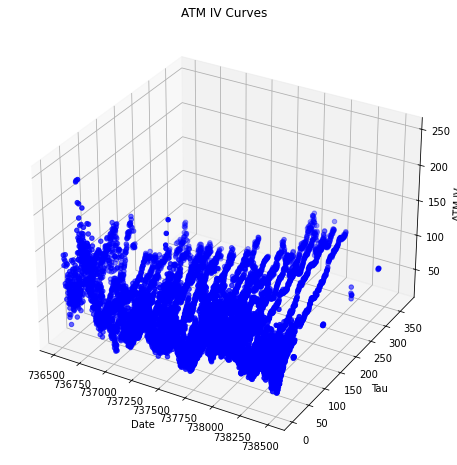

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plotting the 3D graph of ATM IV curves
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare data for plotting
x = iv_atm_df['date'].map(pd.Timestamp.toordinal) # Convert date to ordinal numbers
y = iv_atm_df['tau']
z = iv_atm_df['IV_atm']

# Plot the surface
ax.scatter(x, y, z, c='b', marker='o')

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Tau')
ax.set_zlabel('ATM IV')
ax.set_title('ATM IV Curves')

# Show the plot
plt.show()

In [ ]:
# Create a new DataFrame with 'date' and 'observations' (number of rows per date)
observations_df = df.groupby('date').size().reset_index(name='observations')

# Save the observations DataFrame to a new CSV file
observations_save_path = os.path.join(path, "data", "processed", "20172022_processed_1_3_5_1_observations.csv")
observations_df.to_csv(observations_save_path, index=False)

print("Observations per date saved to '20172022_processed_1_3_5_1_observations.csv'")


Observations per date saved to '20172022_processed_1_3_5_1_observations.csv'


In [65]:
print("The size of df is:", df.shape)

The size of df is: (3090945, 10)


In [66]:
# Create folders for moneyness and standardized moneyness
moneyness_folder = os.path.join(path, "SVI", "IV", "moneyness")
standardized_moneyness_folder = os.path.join(path, "SVI", "IV", "standardized_moneyness")

if not os.path.exists(moneyness_folder):
    os.makedirs(moneyness_folder)

if not os.path.exists(standardized_moneyness_folder):
    os.makedirs(standardized_moneyness_folder)

# Iterate through each unique date to create dataframes for moneyness and standardized moneyness
for date, group in df.groupby('date'):
    # Sort by moneyness and create a DataFrame
    moneyness_df = group.sort_values(by='moneyness')[['moneyness', 'tau', 'IV']]
    moneyness_pivot = moneyness_df.pivot(index='moneyness', columns='tau', values='IV').reset_index()
    moneyness_file_path = os.path.join(moneyness_folder, f"IV_matrix_{date.strftime('%Y-%m-%d')}.csv")
    moneyness_pivot.to_csv(moneyness_file_path, index=False)

    # Sort by standardized moneyness and create a DataFrame
    standardized_moneyness_df = group.sort_values(by='standardized_moneyness')[['standardized_moneyness', 'tau', 'IV']]
    standardized_moneyness_pivot = standardized_moneyness_df.pivot(index='standardized_moneyness', columns='tau', values='IV').reset_index()
    standardized_moneyness_file_path = os.path.join(standardized_moneyness_folder, f"IV_matrix_{date.strftime('%Y-%m-%d')}.csv")
    standardized_moneyness_pivot.to_csv(standardized_moneyness_file_path, index=False)

    print(f"Moneyness and standardized moneyness dataframes saved for date {date.strftime('%Y-%m-%d')}")


Moneyness and standardized moneyness dataframes saved for date 2017-07-01
Moneyness and standardized moneyness dataframes saved for date 2017-07-02
Moneyness and standardized moneyness dataframes saved for date 2017-07-03
Moneyness and standardized moneyness dataframes saved for date 2017-07-04
Moneyness and standardized moneyness dataframes saved for date 2017-07-05
Moneyness and standardized moneyness dataframes saved for date 2017-07-06
Moneyness and standardized moneyness dataframes saved for date 2017-07-07
Moneyness and standardized moneyness dataframes saved for date 2017-07-08
Moneyness and standardized moneyness dataframes saved for date 2017-07-09
Moneyness and standardized moneyness dataframes saved for date 2017-07-10
Moneyness and standardized moneyness dataframes saved for date 2017-07-11
Moneyness and standardized moneyness dataframes saved for date 2017-07-12
Moneyness and standardized moneyness dataframes saved for date 2017-07-13
Moneyness and standardized moneyness d

In [67]:
# Identify duplicate rows with the same moneyness and tau
duplicates = df[df.duplicated(subset=['date', 'moneyness', 'tau'], keep=False)]

# Save duplicates to a CSV file for review
duplicates_save_path = os.path.join(path, "data", "processed", "20172022_duplicates_moneyness_tau.csv")
duplicates.to_csv(duplicates_save_path, index=False)

print("Duplicate rows with the same moneyness and tau saved to '20172022_duplicates_moneyness_tau.csv'")


Duplicate rows with the same moneyness and tau saved to '20172022_duplicates_moneyness_tau.csv'


In [68]:
print(duplicates.head())
print("The shape of duplicates is: ",duplicates.shape)

Empty DataFrame
Columns: [date, tau, putcall, moneyness, quantity, option_price, IV, IV_atm, moneyness_atm, standardized_moneyness]
Index: []
The shape of duplicates is:  (0, 10)


# Filter out option with ttm > 60 days or ttm < 3 days

In [ ]:
import pandas as pd
import numpy as np
import os


path = "/Users/irtg/同步空间/Pricing_Kernel/EPK/matlab_code_for_BTC"
os.chdir(path)

data_path = os.path.join(path, "data", "processed","20172022_processed_1_3_4.csv")

# Load the dataset
df = pd.read_csv(data_path)

# Convert 'date' to datetime type for easy grouping
df['date'] = pd.to_datetime(df['date'])

# Data cleaning
# Drop rows with IV <= 0 or tau < 3
df = df[(df['IV'] > 0) & (df['tau'] >= 3)]
# Drop rows with tau < 3 or tau > 60
df = df[(df['tau'] >= 3) & (df['tau'] <= 60)]

# Filter out rows where 'quantity' is zero before applying aggregation
df = df[df['quantity'] > 0]

# Calculate the moneyness: moneyness = K/S - 1
df['moneyness'] = df['K'] / df['BTC_price'] - 1

# Filter out call options with moneyness < 0 or put options with moneyness > 0
df = df[(df['putcall'] == 'C') & (df['moneyness'] >= 0) | (df['putcall'] == 'P') & (df['moneyness'] <= 0)].reset_index(drop=True)

# Merge rows with the same 'date', 'BTC_price', 'option_price', 'tau', 'K', 'IV', 'putcall' but different 'quantity'
df = df.groupby(['date', 'BTC_price', 'tau', 'K', 'putcall', 'moneyness'], as_index=False).agg({
    'quantity': 'sum',
    'option_price': lambda x: np.average(x, weights=df.loc[x.index, 'quantity']),
    'IV': lambda x: np.average(x, weights=df.loc[x.index, 'quantity'])
    })

# Merge rows with the same 'date', 'tau', 'putcall', 'moneyness' but different 'option_price', 'IV', 'quantity'
df = df.groupby(['date', 'tau', 'putcall', 'moneyness'], as_index=False).agg({
    'quantity': 'sum',
    'option_price': lambda x: np.average(x, weights=df.loc[x.index, 'quantity']),
    'IV': lambda x: np.average(x, weights=df.loc[x.index, 'quantity'])
    })

# Initialize an empty list to store the ATM IV values for each date
iv_atm_list = []
# Iterate through each unique date and tau to find the ATM IV (where moneyness is closest to 0)
for (date, tau), group in df.groupby(['date', 'tau']):
    closest_row = group.iloc[(group['moneyness']).abs().argsort()[:1]]  # Closest row to moneyness = 0
    iv_atm = closest_row['IV'].values[0]
    moneyness_atm = closest_row['moneyness'].values[0]
    iv_atm_list.append({'date': date, 'tau': tau, 'IV_atm': iv_atm, 'moneyness_atm': moneyness_atm})

# Create a DataFrame from the ATM IV list
iv_atm_df = pd.DataFrame(iv_atm_list)

# Merge the ATM IV values back into the original dataframe
df = df.merge(iv_atm_df, on=['date', 'tau'], how='left')

# Calculate standardized moneyness: standardized_moneyness = (K/S - 1) / IV_atm
# Multiply by 100 for scaling
df['standardized_moneyness'] = df['moneyness']/ df['IV_atm'] * 100

# Save the result to a new CSV file
save_path = os.path.join(path, "data", "processed", "20172022_processed_1_3_6_standardized_moneyness.csv")
df.to_csv(save_path, index=False)

print("Standardized moneyness calculation completed and saved to '20172022_processed_1_3_6_standardized_moneyness_TTM3to60.csv'")

# Save the ATM IV values to a new CSV file
save_path = os.path.join(path, "data", "IV", "ATM", "20172022_ATM_IV_TTM3to60.csv")
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
iv_atm_df.to_csv(save_path, index=False)

print("ATM IV values saved to '20172022_ATM_IV_TTM3to60.csv'")



Standardized moneyness calculation completed and saved to '20172022_processed_1_3_6_standardized_moneyness_TTM3to60.csv'
ATM IV values saved to '20172022_ATM_IV_TTM3to60.csv'


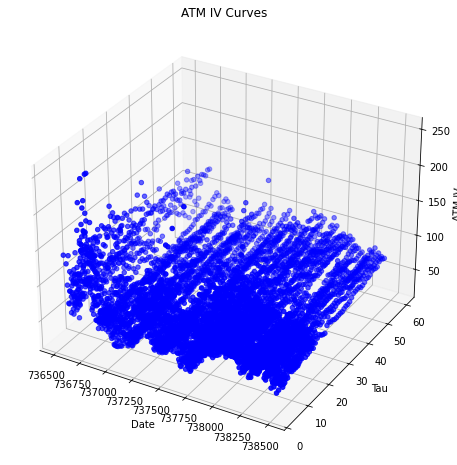

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plotting the 3D graph of ATM IV curves
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare data for plotting
x = iv_atm_df['date'].map(pd.Timestamp.toordinal) # Convert date to ordinal numbers
y = iv_atm_df['tau']
z = iv_atm_df['IV_atm']

# Plot the surface
ax.scatter(x, y, z, c='b', marker='o')

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Tau')
ax.set_zlabel('ATM IV')
ax.set_title('ATM IV Curves')

# Show the plot
plt.show()

In [71]:
# Create a new DataFrame with 'date' and 'observations' (number of rows per date)
observations_df = df.groupby('date').size().reset_index(name='observations')

# Save the observations DataFrame to a new CSV file
observations_save_path = os.path.join(path, "data", "processed", "20172022_processed_1_3_5_2_observations_ttm3to60.csv")
observations_df.to_csv(observations_save_path, index=False)

print("Observations per date saved to '20172022_processed_1_3_5_2_observations_ttm3to60.csv'")

print("The size of df is:", df.shape)


Observations per date saved to '20172022_processed_1_3_5_2_observations_ttm3to60.csv'
The size of df is: (2509390, 10)


In [72]:
# Create folders for moneyness and standardized moneyness
moneyness_folder = os.path.join(path, "SVI", "IV", "moneyness","ttm3to60")
standardized_moneyness_folder = os.path.join(path, "SVI", "IV", "standardized_moneyness","ttm3to60")

if not os.path.exists(moneyness_folder):
    os.makedirs(moneyness_folder)

if not os.path.exists(standardized_moneyness_folder):
    os.makedirs(standardized_moneyness_folder)

# Iterate through each unique date to create dataframes for moneyness and standardized moneyness
for date, group in df.groupby('date'):
    # Sort by moneyness and create a DataFrame
    moneyness_df = group.sort_values(by='moneyness')[['moneyness', 'tau', 'IV']]
    moneyness_pivot = moneyness_df.pivot(index='moneyness', columns='tau', values='IV').reset_index()
    moneyness_file_path = os.path.join(moneyness_folder, f"IV_matrix_{date.strftime('%Y-%m-%d')}.csv")
    moneyness_pivot.to_csv(moneyness_file_path, index=False)

    # Sort by standardized moneyness and create a DataFrame
    standardized_moneyness_df = group.sort_values(by='standardized_moneyness')[['standardized_moneyness', 'tau', 'IV']]
    standardized_moneyness_pivot = standardized_moneyness_df.pivot(index='standardized_moneyness', columns='tau', values='IV').reset_index()
    standardized_moneyness_file_path = os.path.join(standardized_moneyness_folder, f"IV_matrix_{date.strftime('%Y-%m-%d')}.csv")
    standardized_moneyness_pivot.to_csv(standardized_moneyness_file_path, index=False)

    print(f"Moneyness and standardized moneyness dataframes saved for date {date.strftime('%Y-%m-%d')}")


Moneyness and standardized moneyness dataframes saved for date 2017-07-01
Moneyness and standardized moneyness dataframes saved for date 2017-07-02
Moneyness and standardized moneyness dataframes saved for date 2017-07-03
Moneyness and standardized moneyness dataframes saved for date 2017-07-04
Moneyness and standardized moneyness dataframes saved for date 2017-07-05
Moneyness and standardized moneyness dataframes saved for date 2017-07-06
Moneyness and standardized moneyness dataframes saved for date 2017-07-07
Moneyness and standardized moneyness dataframes saved for date 2017-07-08
Moneyness and standardized moneyness dataframes saved for date 2017-07-09
Moneyness and standardized moneyness dataframes saved for date 2017-07-10
Moneyness and standardized moneyness dataframes saved for date 2017-07-11
Moneyness and standardized moneyness dataframes saved for date 2017-07-12
Moneyness and standardized moneyness dataframes saved for date 2017-07-13
Moneyness and standardized moneyness d